<a href="https://colab.research.google.com/github/hamsterjoa/Home-Credit-Default-Risk/blob/main/Home-Credit-Default-Risk(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Import Data & Libraries

In [2]:
# Data manipulation
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Modeling
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Ignore warnings
import sys
import warnings

if not sys.warnoptions:
  warnings.simplefilter('ignore')

In [3]:
# Import main data
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/패스트캠퍼스/data/application_train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/패스트캠퍼스/data/application_test.csv')

# Import supplymentary data
bureau = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/패스트캠퍼스/data/bureau.csv')
bureau_balance = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/패스트캠퍼스/data/bureau_balance.csv')
pos = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/패스트캠퍼스/data/POS_CASH_balance.csv')
installment = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/패스트캠퍼스/data/installments_payments.csv')
credit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/패스트캠퍼스/data/credit_card_balance.csv')
p_app = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/패스트캠퍼스/data/previous_application.csv')

In [4]:
# Training data
print('Training data shape: ', train.shape)
print('Training data columns: ', train.columns)
train.head()

Training data shape:  (307511, 122)
Training data columns:  Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Testing data
print('Testing data shape: ', test.shape)
print('Testing data columns: ', test.columns)
test.head()

Testing data shape:  (48744, 121)
Testing data columns:  Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

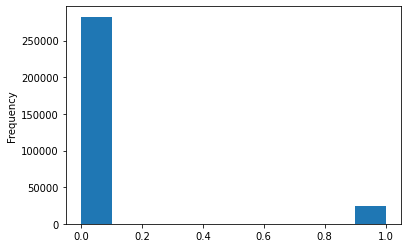

In [7]:
train['TARGET'].astype(int).plot.hist()

위의 value_counts()를 통해 TARGET 칼럼이 불균형 데이터라는 것을 알 수 있습니다. 제 시간에 대출을 상환을 한 사람이 그렇지 않은 사람보다 훨씬 많습니다. 좀 더 정교한 머신러닝 모델에 들어가면, 불균형을 반영하기 위해 데이터 표현에 따라 클래스에 가중치를 부여할 수 있습니다.

## 2. Data Cleaning

### 2-1. Train/Test Data

#### A. Separate Data Types

In [8]:
train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [9]:
# Create a dataframe of only categorical variables
cat_train = train.select_dtypes(['object'])
cat_test = test.select_dtypes(['object'])

# Create a dataframe of only numerical variables
num_train = train.select_dtypes(['int64', 'float64'])
num_test = test.select_dtypes(['int64', 'float64'])

In [10]:
# Categorical data
cat_train.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN,NaN,NaN,NaN


In [11]:
# Numerical data
num_train.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# 각 개체 열의 고유 클래스 수
cat_train.apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [13]:
# 이진 열을 부울로 변환
bi_cols = []

# 각 열을 반복하고 bi_cols 목록에 2개의 값만 있는 모든 열을 저장
for col in cat_train.columns:
  if len(list(cat_train[col].unique())) <= 2:
    bi_cols.append(col)

cat_train[bi_cols].head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY
0,Cash loans,N,Y
1,Cash loans,N,N
2,Revolving loans,Y,Y
3,Cash loans,N,Y
4,Cash loans,N,Y


**Label Encoding**

문자열 값들을 숫자형으로 변경

In [14]:
le = LabelEncoder()

for col in bi_cols:
  cat_train[col] = le.fit_transform(cat_train[col])
  cat_test[col] = le.fit_transform(cat_test[col])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [15]:
cat_train[bi_cols].head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY
0,0,0,1
1,0,0,0
2,1,1,1
3,0,0,1
4,0,0,1


**One-Hot Encoding**

고유값에 해당하는 칼럼에는 1, 나머지에는 0을 표시

In [16]:
# pd.get_dummies를 사용하여 OHE를 수행하면 이 방법은 누락된 값을 대치할 필요가 없음
cat_train = pd.get_dummies(cat_train)
cat_test = pd.get_dummies(cat_test)

print('Training Features shape: ', cat_train.shape)
print('Testing Features shape: ', cat_test.shape)

Training Features shape:  (307511, 137)
Testing Features shape:  (48744, 134)


In [17]:
# num_df와 cat_df를 하나의 새 DataFrame으로 결합
encoded_train = pd.concat([num_train, cat_train], axis=1)
encoded_test = pd.concat([num_test, cat_test], axis=1)

**Find Correlation**

In [18]:
def correlations(number) :
    # 대상과의 상관관계 찾고 정렬
    correlations = encoded_train.corr()['TARGET'].sort_values()

    # 상관 관계 표시
    print('Most Positive Correlations:\n', correlations.tail(20))
    print('\nMost Negative Correlations:\n', correlations.head(20))

In [19]:
correlations(10)

Most Positive Correlations:
 OCCUPATION_TYPE_Drivers                              0.030303
DEF_60_CNT_SOCIAL_CIRCLE                             0.031276
DEF_30_CNT_SOCIAL_CIRCLE                             0.032248
LIVE_CITY_NOT_WORK_CITY                              0.032518
OWN_CAR_AGE                                          0.037612
DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                 

상관계수 일반적인 해석
- .00-.19 : very weak
- .20-.39 : weak
- .40-.59 : moderate
- .60-.79 : strong
- .80-1.0 :very strong

*=> TARGET과 DAYS_BIRTH의 상관관계가 가장 높은 것으로 확인됩니다.*

#### B. Outliers

DAYS_BIRTH 칼럼들의 값은 현재 대출 신청을 기준으로 기록되기 때문에 음수입니다. 연도 단위로 보려면 -1을 곱하고 365로 나눌 수 있습니다.

In [20]:
# DAYS_BIRTH
(encoded_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

연도는 비정상적인 값이 없습니다.

In [21]:
# DAYS_EMPLOYED
encoded_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

비정상적인 값이 있어 보입니다. max 값은 약 1000년 정도가 됩니다

Text(0.5, 0, 'Days Employment')

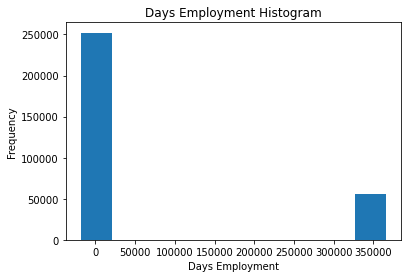

In [22]:
encoded_train["DAYS_EMPLOYED"].plot.hist(title="Days Employment Histogram")
plt.xlabel("Days Employment")

비정상적인 값으로 여겨지는 보객들을 하위 집합으로 분류하고 다른 고객들에 비해 채무 불이행 비율이 높거나 낮은 경향이 있는지 살펴봅시다.

In [23]:
anom = encoded_train[encoded_train['DAYS_EMPLOYED'] == 365243] ## max
non_anom = encoded_train[encoded_train['DAYS_EMPLOYED'] != 365243]

print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


비정상적인 값으로 여겨지는 고객들의 채무 불이행 비율이 더 낮은 것으로 나타납니다.

예외 처리는 정해진 규칙 없이 상황에 따라 다릅니다. 가장 안전한 접근 방식 중 하나는 예외를 결측값으로 설정한 다음 값을 채워넣는 것입니다. 이 경우 모든 이상치 값이 정확히 같으므로 이러한 대출이 모두 공통적인 어떤 것을 공유할 것으로 가정해 동일한 값으로 채웁니다.

여기서는 비정상적인 값을 가지는 값을 np.nan로 값을 바꾼 다음, 값의 비정상 여부를 나타내는 새로운 칼럼을 만듭니다.

In [24]:
# 변칙 플래그 열 생성
encoded_train['DAYS_EMPLOYED_ANOM'] = encoded_train["DAYS_EMPLOYED"] == 365243
encoded_test['DAYS_EMPLOYED_ANOM'] = encoded_test["DAYS_EMPLOYED"] == 365243

# 비정상적인 값 nan으로 교체
encoded_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
encoded_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (encoded_test["DAYS_EMPLOYED_ANOM"].sum(), len(encoded_test)))

There are 9274 anomalies in the test data out of 48744 entries


Text(0.5, 0, 'Days Employment')

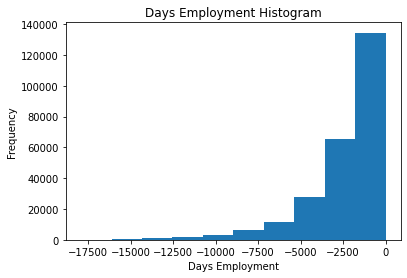

In [25]:
encoded_train["DAYS_EMPLOYED"].plot.hist(title="Days Employment Histogram")
plt.xlabel("Days Employment")

분포는 우리가 예상하는 것과 훨씬 더 비슷한 것으로 보이며, 이러한 값이 원래 비정상임을 모델에 알려주는 새로운 컬럼도 만들었습니다. (NaN 값을 아마 컬럼의 median으로 채워야하기 때문에)

비정상적인 값을 제외한 값들은 이상치가 없어 보입니다.

### 2-2. Supplemental Data

**Aggregation of numeric variables**

In [26]:
def agg_numeric(df, group_var, df_name):
    # 그룹화 변수 이외의 id 변수 제거
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)

    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = df[group_var]

    # 지정된 변수로 그룹화 및 통계 계산
    agg = numeric_df.groupby(group_var).agg(['count','mean','max','min','sum']).reset_index()

    # 새로운 열 생성
    columns = [group_var]

    for var in agg.columns.levels[0]:
      if var != group_var:

        # [:-1] 인덱스 열이 ''이기 때문에
        for stat in agg.columns.levels[1][:-1]:
          columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

**Aggregation of categorical variables**

count_categorical 함수는 범주형 데이터에 대해 OHE를 수행하고 각 열에 대해 각 값의 합계와 비율을 계산합니다.

In [27]:
# 우리는 6개의 보조 테이블을 가지고 있으며 그것들을 함께 결합하고 SK_ID_CURR을 사용하여 메인 테이블과 병합해야 함
def count_categorical(df, group_var, df_name):

  # 범주형 데이터를 가져와서 OHE을 수행
  cat = pd.get_dummies(df.select_dtypes('object'))

  # add the id
  cat[group_var] = df[group_var]

  # aggregate by id
  cat = cat.groupby(group_var).agg(['sum','mean'])

  column_names = []

  # for each first level column name, we define a new column name
  for var in cat.columns.levels[0]:
      for stat in ['count', 'count_norm']:
          # Make a new column name
          column_names.append('%s_%s_%s' % (df_name, var, stat))

  cat.columns = column_names

  return cat

**Aggregation for each supplemental table**

In [28]:
# Bureau
bureau_counts = count_categorical(bureau, group_var='SK_ID_CURR', df_name='bureau')
bureau_agg = agg_numeric(bureau.drop(columns=["SK_ID_BUREAU"]),
                         group_var="SK_ID_CURR",
                         df_name="bureau")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [29]:
# Bureau balance
bureau_balance_counts = count_categorical(bureau_balance, group_var="SK_ID_BUREAU",
                                          df_name="bureau_balance")
bureau_balance_agg = agg_numeric(bureau_balance, group_var="SK_ID_BUREAU",
                                 df_name="bureau_balance")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index=True,
                                           left_on="SK_ID_BUREAU", how="outer")

bureau_by_loan = bureau[["SK_ID_BUREAU", "SK_ID_CURR"]].merge(bureau_by_loan,
                                                              on="SK_ID_BUREAU",
                                                              how="left")

bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns=["SK_ID_BUREAU"]),
                                       group_var="SK_ID_CURR",
                                       df_name="client")

In [31]:
# Pos
pos_counts = count_categorical(pos, group_var = 'SK_ID_CURR', df_name = 'os')
pos_agg = agg_numeric(pos, group_var = 'SK_ID_CURR', df_name = 'pos')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
# Installment
installment_agg = agg_numeric(installment, group_var = 'SK_ID_CURR', df_name = 'installment')

In [33]:
# Credit
credit_counts = count_categorical(credit, group_var = 'SK_ID_CURR', df_name = 'credit')
credit_agg = agg_numeric(credit, group_var = 'SK_ID_CURR', df_name = 'credit')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
# p_app
p_app_counts = count_categorical(p_app, group_var = 'SK_ID_CURR', df_name = 'p_app')
p_app_agg = agg_numeric(p_app, group_var = 'SK_ID_CURR', df_name = 'p_app')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Merge with train and test table**

In [35]:
# Merge with the train
encoded_train = encoded_train.merge(bureau_counts, on="SK_ID_CURR", how="left")
encoded_train = encoded_train.merge(bureau_agg, on="SK_ID_CURR", how="left")
encoded_train = encoded_train.merge(bureau_balance_by_client, on="SK_ID_CURR", how="left")

encoded_train = encoded_train.merge(pos_counts, on = 'SK_ID_CURR', how = 'left')
encoded_train = encoded_train.merge(pos_agg, on = 'SK_ID_CURR', how = 'left')

encoded_train = encoded_train.merge(installment_agg, on = 'SK_ID_CURR', how = 'left')

encoded_train = encoded_train.merge(credit_counts, on = 'SK_ID_CURR', how = 'left')
encoded_train = encoded_train.merge(credit_agg, on = 'SK_ID_CURR', how = 'left')

encoded_train = encoded_train.merge(p_app_counts, on = 'SK_ID_CURR', how = 'left')
encoded_train = encoded_train.merge(p_app_agg, on = 'SK_ID_CURR', how = 'left')

In [36]:
# Merge with the test
encoded_test = encoded_test.merge(bureau_counts, on="SK_ID_CURR", how="left")
encoded_test = encoded_test.merge(bureau_agg, on="SK_ID_CURR", how="left")
encoded_test = encoded_test.merge(bureau_balance_by_client, on="SK_ID_CURR", how="left")

encoded_test = encoded_test.merge(pos_counts, on = 'SK_ID_CURR', how = 'left')
encoded_test = encoded_test.merge(pos_agg, on = 'SK_ID_CURR', how = 'left')

encoded_test = encoded_test.merge(installment_agg, on = 'SK_ID_CURR', how = 'left')

encoded_test = encoded_test.merge(credit_counts, on = 'SK_ID_CURR', how = 'left')
encoded_test = encoded_test.merge(credit_agg, on = 'SK_ID_CURR', how = 'left')

encoded_test = encoded_test.merge(p_app_counts, on = 'SK_ID_CURR', how = 'left')
encoded_test = encoded_test.merge(p_app_agg, on = 'SK_ID_CURR', how = 'left')

In [37]:
print('Training set full shape: ', encoded_train.shape)
print('Testing set full shape: ' , encoded_test.shape)

Training set full shape:  (307511, 1023)
Testing set full shape:  (48744, 1019)


In [38]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

Training Data Shape:  (307511, 122)
Testing Data Shape:  (48744, 121)


In [39]:
copy_encoded_train = encoded_train.copy()
copy_encoded_test = encoded_test.copy()

## 3. Feature Selection

### 3-1. Missing Vallues

In [40]:
# nan 값을 합하고 데이터프레임 길이로 나누어 비율 계산
prop_na = encoded_train.isna().sum() / len(encoded_train)
# 5% 미만의 nan 값이 있는 열을 필터링
prop_na = prop_na[prop_na > 0.3]
prop_na = prop_na.sort_values(0, ascending=True).rename('missing_perc').reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only
  """


In [41]:
prop_na.head(10)

,index,missing_perc
0,bureau_AMT_CREDIT_MAX_OVERDUE_mean,0.402018
1,bureau_AMT_CREDIT_MAX_OVERDUE_min,0.402018
2,bureau_AMT_CREDIT_MAX_OVERDUE_max,0.402018
3,TOTALAREA_MODE,0.482685
4,YEARS_BEGINEXPLUATATION_MEDI,0.487810
5,YEARS_BEGINEXPLUATATION_AVG,0.487810
6,YEARS_BEGINEXPLUATATION_MODE,0.487810
7,FLOORSMAX_MEDI,0.497608
8,FLOORSMAX_AVG,0.497608
9,FLOORSMAX_MODE,0.497608


In [42]:
def remove_missing(df_train, df_test, thredhold):

  # 누락된 열 및 누락된 값 백분율 가져오기
  train_missing = (df_train.isnull().sum() / len(df_train)).sort_values(ascending = False)
  test_missing = (df_test.isnull().sum() / len(df_test)).sort_values(ascending = False)

  # 임계값으로 누락된 값 필터링
  train_missing = train_missing.index[train_missing > thredhold]
  test_missing = test_missing.index[test_missing > thredhold]

  # train 및 test의 결측값 열 결합
  all_missing = list(set(set(train_missing) | set(test_missing)))
  print('There are %d columns with more than %s%% missing values' % (len(all_missing), thredhold))

  # target column 저장
  train_labels = train["TARGET"]

  # 누락된 값 열 삭제
  df_train = df_train.drop(columns = all_missing)
  df_test = df_test.drop(columns = all_missing)

  # train 데이터와 test 데이터의 컬럼을 맞추기 위해 align 함수 사용
  df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)
  df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)

  df_train["TARGET"] = train_labels

  print('Training set full shape: ', df_train.shape)
  print('Testing set full shape: ' , df_test.shape)

  return df_train, df_test

In [43]:
encoded_train, encoded_test = remove_missing(encoded_train, encoded_test, 0.60)

There are 202 columns with more than 0.6% missing values
Training set full shape:  (307511, 818)
Testing set full shape:  (48744, 817)


### 3-2. Feature Importance

In [44]:
# id 열 저장 및 제거
train_id = encoded_train['SK_ID_CURR']
test_id = encoded_test['SK_ID_CURR']

encoded_train = encoded_train.drop('SK_ID_CURR', axis=1)
encoded_test = encoded_test.drop('SK_ID_CURR', axis=1)

In [45]:
# train data의 target 열 저장 및 제거
target_train = encoded_train['TARGET']
encoded_train = encoded_train.drop('TARGET', axis=1)

In [46]:
encoded_train.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,p_app_DAYS_TERMINATION_count,p_app_DAYS_TERMINATION_mean,p_app_DAYS_TERMINATION_max,p_app_DAYS_TERMINATION_min,p_app_DAYS_TERMINATION_sum,p_app_NFLAG_INSURED_ON_APPROVAL_count,p_app_NFLAG_INSURED_ON_APPROVAL_mean,p_app_NFLAG_INSURED_ON_APPROVAL_max,p_app_NFLAG_INSURED_ON_APPROVAL_min,p_app_NFLAG_INSURED_ON_APPROVAL_sum
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,...,1.0,-17.000000,-17.0,-17.0,-17.0,1.0,0.000000,0.0,0.0,0.0
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,...,3.0,-1047.333333,-527.0,-1976.0,-3142.0,3.0,0.666667,1.0,0.0,2.0
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,...,1.0,-714.000000,-714.0,-714.0,-714.0,1.0,0.000000,0.0,0.0,0.0
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,...,4.0,182481.750000,365243.0,-416.0,729927.0,4.0,0.000000,0.0,0.0,0.0
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,-3458,...,5.0,72143.800000,365243.0,-2041.0,360719.0,5.0,0.600000,1.0,0.0,3.0


In [47]:
# 열 이름 형식 지정
encoded_train.columns = [''.join (c if c.isalnum() else '_' for c in str(x)) for x in encoded_train.columns]
encoded_test.columns = [''.join (c if c.isalnum() else '_' for c in str(x)) for x in encoded_test.columns]

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


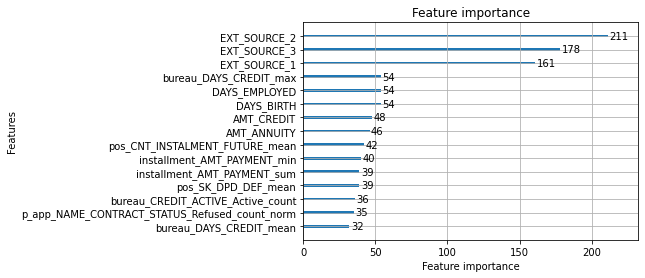

In [48]:
# LightGBM 모델을 구축하여 중요한 기능 선택
d_train = lgb.Dataset(encoded_train, label=target_train)
param = {'max_depth': 5, 'learning_rate' : 0.1, 'num_leaves': 900, 'n_estimators': 100}
model = lgb.train(params=param,train_set=d_train)
ax = lgb.plot_importance(model, max_num_features=15)
plt.show()

In [49]:
feature_important_thredhold = 5
feature_important = {model.feature_name()[i]:model.feature_importance()[i]  for i in range(len(model.feature_importance()))}
LGBM_features_columns = [d for d in feature_important if feature_important[d] > feature_important_thredhold]
print(f'There are {len(encoded_train[LGBM_features_columns].columns)} important features after LightGBM selection.')

There are 120 important features after LightGBM selection.


### 3-3. Correlation

In [50]:
correlation_threshold = 0.8

# Calculating an absolute value correlation matrix
corr_mat = encoded_train[LGBM_features_columns].corr().abs()

# Getting upper triangle of this matrix only
upper = pd.DataFrame(np.triu(corr_mat, k=1), columns=encoded_train[LGBM_features_columns].columns)

# Select columns with correlations above threshold
corr_col_drop = [col for col in upper.columns if any(upper[col] > correlation_threshold)]

print(f'There are {len(corr_col_drop)} columns to remove out of {len(encoded_train[LGBM_features_columns].columns)}.')

There are 34 columns to remove out of 120.


In [51]:
encoded_train_if = encoded_train[LGBM_features_columns].drop(corr_col_drop, axis=1)
encoded_test_if = encoded_test[LGBM_features_columns].drop(corr_col_drop, axis=1)

정리된 테이블 요약
- feature selection한 훈련 데이터 : encoded_train_if
- feature selection한 테스트 데이터: encoded_test_if
- 대상 훈련 데이터: target_train

### 3-4. PCA

feature 수가 많을 경우 curse of dimensionality(차원의 저주)가 생겨 차원을 줄여줘야 합니다. PCA란 주성분 분석으로, 가장 많이 사용되는 차원 축소 알고리즘 입니다.

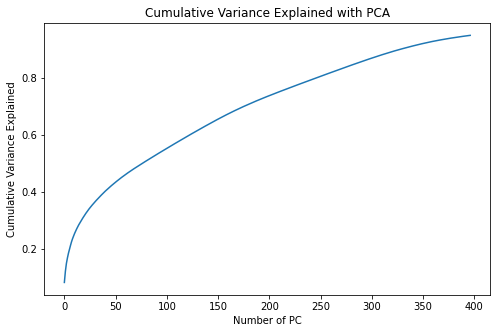

In [52]:
# define the number of components
n_comp=.95

# create a pca pipeline with median imputation
pipeline = Pipeline(steps = [('scaler', StandardScaler()),
                             ('imputer', SimpleImputer(strategy = 'median')),
                             ('pca', PCA(n_components=n_comp, svd_solver='full', random_state=1))])

pca = pipeline.named_steps['pca']

pipeline.fit(encoded_train)

train_pca = pipeline.transform(encoded_train)
test_pca = pipeline.transform(encoded_test)

plt.figure(figsize = (8, 5))
plt.plot(list(range(train_pca.shape[1])), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of PC'); plt.ylabel('Cumulative Variance Explained');
plt.title('Cumulative Variance Explained with PCA');

In [53]:
# Select top n princple features
total_variance_explained = 0
print('individual variance contributions:')

for j in range(12):
  print(pca.explained_variance_ratio_[j])
  total_variance_explained += pca.explained_variance_ratio_[j]

print('Explained variance: %.4f' % total_variance_explained)

individual variance contributions:
0.08092277903949342
0.03929892791923566
0.027800843521920075
0.01934998174949711
0.01653549275284451
0.014266479181857427
0.013186576536191671
0.012812623410320982
0.010899244481864526
0.009577103018700201
0.008796998000314409
0.008089880724839885
Explained variance: 0.2615


In [54]:
df_pca_train = pd.DataFrame(data=train_pca)
df_pca_test = pd.DataFrame(data=test_pca)

여기서 우리는 여전히 많은 변수가 있기 때문에 pca가 유용하지 않다는 것을 알 수 있습니다.

In [55]:
# export cvs file
encoded_train_if['TARGET'] = target_train

encoded_train_if.to_csv('/content/drive/MyDrive/Colab Notebooks/패스트캠퍼스/encoded_train_if.csv')
encoded_test_if.to_csv('/content/drive/MyDrive/Colab Notebooks/패스트캠퍼스/encoded_test_if.csv')